In [1]:
import os
import pandas as pd
import numpy as np 
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.util import ngrams
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import SnowballStemmer    
from nltk.stem import WordNetLemmatizer
import timeit


#mnb imports
# Naive bayes with hyper parameter tuning
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

#cnn imports
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import sys
import pathlib

#tuning
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

sns.set()


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def getData(path):
    dataList = list()
    for subdir, dirs, files in os.walk(path):
        for file in files:
            #print(os.path.join(subdir, file))
            f = open(subdir+"/"+file, "r")
            dataList.append(f.read())
    return dataList
            
def avgWordCount(wordList):
    wordCount = 0
    for wordArray in wordList:
        wordCount += len(wordArray)
    wordAverage = wordCount/len(wordList)
    return wordAverage          


def preprocess(dataList, allPreprocessing = False):
    # https://textblob.readthedocs.io/en/dev/
    wordList = list()
    wordListStem = list()
    wordListLemmatized = list()
    
    # stemming / lemmatization
    # https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8
    wordnet_lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer(language='english')

    stops = set(stopwords.words("english"))
    for text in dataList:
            # lowercase
            textLowercase = text.lower()
            # remove digits (not sure if we should do this, ad does is in the slides)
            textFiltered = re.sub(r'\b[0-9]+\b\s*', '', textLowercase)
            #print(text)
            # get textblob
            blob = TextBlob(textFiltered)
            # tokenize
            words = blob.words
            #print(words)
            if (allPreprocessing):
                # remove stopwords and stem
                wordsFiltered_stem = [stemmer.stem(word.correct()) for word in words if word not in stopwords.words('english')]
                wordsFiltered_lemmatized = [wordnet_lemmatizer.lemmatize(word.correct()) for word in words if word not in stopwords.words('english')]
                wordsFiltered = [word.correct() for word in words if word not in stopwords.words('english')]
                #print(wordsFiltered)
                wordList.append(wordsFiltered)
                wordListStem.append(wordsFiltered_stem)
                wordListLemmatized.append(wordsFiltered_lemmatized)
            else:
                wordsFiltered = [word.correct() for word in words if word not in stopwords.words('english')]
                wordList.append(wordsFiltered)
                
    if (allPreprocessing):            
        return (wordList, wordListStem, wordListLemmatized)
    else:
        return wordList

"""
https://www.mygreatlearning.com/blog/bag-of-words/#ed4
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
Calculate bag of words representation 
datasets: array with test data in first slot and training data in second slot
ngram: corresponding ngram: (1,1) for unigrams, (2,2) for bigrams
classDist = class distribution of the datasets. default assumes no prior changes to the data structure
return: each return consists of 2 dataframes: first dataframe is test data, second data is train data. 
        bag_of_words_data holds features with absolute count; bag_of_words_data_freq has word frequencies
"""
def bagOfWords(datasets, ngram, classDist = [np.repeat([0,1], 80),np.repeat([0,1], 320)]):
    # hyperparameters: max features, use_idf                                             
    vectorizer = CountVectorizer(ngram_range=ngram)#, max_features=750)
    bag_of_words_data_freq = list()
    bag_of_words_data = list()                                         
    tf_transformer = TfidfTransformer()#use_idf=True)
    for idx, dataset in enumerate(datasets):
        # reconcatenate data to sentence which is needed for countvectorizer
        concatTexts = list()
        for text in dataset:
            concatTexts.append(' '.join(text))
        # create bag of words representation
        if(idx == 0):
            countData = vectorizer.fit_transform(concatTexts)
        else:
            countData = vectorizer.transform(concatTexts)

        cv_df=pd.DataFrame(countData.toarray(),columns=vectorizer.get_feature_names())
        cv_df['class_target']=classDist[idx]
        bag_of_words_data.append(cv_df)

        freqData = tf_transformer.fit_transform(countData)
        
        cv_df_freq=pd.DataFrame(freqData.toarray(),columns=vectorizer.get_feature_names())
        cv_df_freq['class_target']=classDist[idx]
        bag_of_words_data_freq.append(cv_df_freq)
    return (bag_of_words_data, bag_of_words_data_freq, vectorizer)


"""
Calculate metrics for a model and plot the confusion matrix
actual: array with actual classes
pred: array with predicted classes
return: confusion matrix and a tuple with 3 values of accuracy, precision and recall
"""
def getModelInfo(actual, pred):
    df_confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    acc = (df_confusion[1][1] + df_confusion[0][0]) / (df_confusion[0]["All"] + df_confusion[1]["All"])
    prec = (df_confusion[1][1] / df_confusion[1]["All"])
    recall = (df_confusion[1][1] / df_confusion["All"][1])
    f1 =  2*((prec*recall)/(prec+recall))
    metrics = (acc, prec, recall, f1)
    plot_confusion_matrix(df_confusion)
    print("Metrics: \n   Accuracy: %f \n   Precision: %f \n   Recall: %f \n   F1: %f" % metrics)
    return df_confusion, metrics
"""
Plot the confusion matrix as a heatmap
df_confusion: confusion matrix from a model
return: nothing
"""
def plot_confusion_matrix(df_confusion):
    sns.heatmap(df_confusion, annot=True, fmt="d")
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    return

def plotMetricsComparison(metrics_list, title=""):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"], index=["Multinomial Naive Bayes", "CNN", "CNN + Glove Embedding"])
    metrics_df.index.name = "Algorithm"
    print(metrics_df.transpose())
    ax = metrics_df.transpose().plot(kind='bar', legend=True, width=0.8, figsize=(10,6))
    plt.legend(loc='lower right')
    plt.xticks(fontsize=14, rotation=0)
    plt.savefig("plots/" + title + '.png')
    plt.show()
    
    
    print(metrics_df)
    
def save_metrics(metrics_list, title="metrics"):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"])
    metrics_df = metrics_df.applymap(lambda x: round(x, 4))
    metrics_df.insert(loc=0, column='Algorithm', value=["Multinomial Naive Bayes", "CNN", "CNN + Glove Embedding"])
    #metrics_df.insert(loc=0, column='Algorithm', value=[item for item in ["Multinomial naive Bayes","Logistic regression","Decision tree", "Random forest"] for i in range(3)])

    # round to 4 decimal places and save to csv file
    metrics_df.to_csv("tables/" + title + ".csv", sep = "&", index=False)
    
# helper function for calculating word frequency
def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o
        

# calculate word frequency
def get_sorted_word_count_n(dataset, n):
    words = (list(traverse(dataset)))
    word_count = {i:words.count(i) for i in set(words)}
    word_count_sorted = dict(sorted(word_count.items(), key=lambda item: item[1], reverse = True))
    return ({k: word_count_sorted[k] for k in list(word_count_sorted)[:n]}, word_count_sorted)

def plot_word_count(word_count, filename):
    plt.figure(figsize=(11, 7))
    bars = plt.bar(range(len(word_count)), list(word_count.values()), align='center')
    plt.xticks(range(len(word_count)), list(word_count.keys()), rotation=90, fontsize=20)
    plt.yticks(fontsize=18)
    plt.ylabel('Word count', fontsize=20)
    # access the bar attributes to place the text in the appropriate location
    for bar in bars:
        yval = bar.get_height()
        if(yval == 1583):
            plt.text(bar.get_x() + -.15, yval + 10, yval, fontsize=16)
        else:    
            plt.text(bar.get_x() + .05, yval + 10, yval, fontsize=16)
    
    plt.tight_layout()
    plt.savefig('plots/'+ filename +'.png', dpi=500)
    plt.show()

In [3]:
deceptive_test = getData(r"data\deceptive\test")
deceptive_train = getData(r"data\deceptive\train")
truthful_test = getData(r"data\truthful\test")
truthful_train = getData(r"data\truthful\train")
post_deceptive_test = preprocess(deceptive_test)
post_deceptive_train = preprocess(deceptive_train)
post_truthful_test = preprocess(truthful_test)
post_truthful_train = preprocess(truthful_train)

In [33]:
datasets = [post_deceptive_test + post_truthful_test, post_deceptive_train + post_truthful_train]
bag_of_words_data, bag_of_words_data_freq, vectorizer = bagOfWords(datasets = datasets, ngram = (1,1))
    
bag_of_words_test = bag_of_words_data[0]
bag_of_words_train = bag_of_words_data[1]
y_test = np.array(bag_of_words_test[['class_target']].values.ravel())
X_test = bag_of_words_test.drop('class_target', axis=1)
y_train = np.array(bag_of_words_train[['class_target']].values.ravel())
X_train = bag_of_words_train.drop('class_target', axis=1)


In [41]:
print("number of features: " + str(X_train.shape[1]))

number of features: 2176


In [6]:
# create metrics list for comparison of different algorithms
metrics_list = list()

word_count_sorted_top_20, wc_total = get_sorted_word_count_n(datasets, 20)
word_count_sorted_top_20_deceptive, wc_dec_total = get_sorted_word_count_n(post_deceptive_train + post_deceptive_test, 20)
word_count_sorted_top_20_truthful, wc_truth_total = get_sorted_word_count_n(post_truthful_train + post_truthful_test, 20)

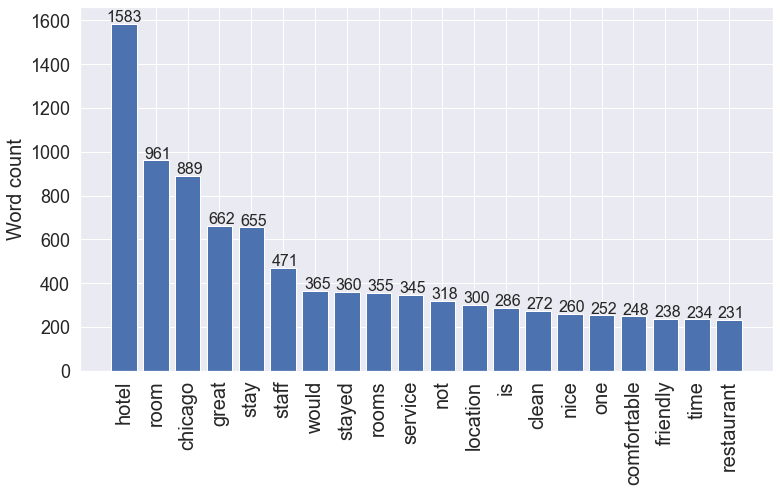

In [71]:
plot_word_count(word_count_sorted_top_20, "word_count_total")

In [51]:
word_count_dec_truth = {}
# get top 20 words of truthful and deceptive - save values in tuple of form key:"word" | value:(deceptive_value, truthful_value)
for (key_dec, value_dec), (key_truth, value_truth) in zip(word_count_sorted_top_20_deceptive.items(), word_count_sorted_top_20_truthful.items()):
    value_truth_1 = 0
    if word_count_sorted_top_20_truthful.get(key_dec) is not None:
        value_truth_1 = word_count_sorted_top_20_truthful.get(key_dec)
    value_dec_1 = 0
    if word_count_sorted_top_20_deceptive.get(key_dec) is not None:
        value_dec_1 = word_count_sorted_top_20_deceptive.get(key_dec)    
    word_count_dec_truth[key_dec] = (value_dec_1, value_truth_1)
    
    if key_truth not in word_count_dec_truth.keys():
        value_truth_2 = 0
        if word_count_sorted_top_20_truthful.get(key_truth) is not None:
            value_truth_2 = word_count_sorted_top_20_truthful.get(key_truth)
        value_dec_2 = 0
        if word_count_sorted_top_20_deceptive.get(key_truth) is not None:
            value_dec_2 = word_count_sorted_top_20_deceptive.get(key_truth)
        word_count_dec_truth[key_truth] = (value_dec_2, value_truth_2)
word_count_dec_truth

{'hotel': (871, 712),
 'chicago': (589, 300),
 'room': (414, 547),
 'great': (256, 406),
 'stay': (356, 299),
 'staff': (220, 251),
 'rooms': (183, 172),
 'location': (0, 214),
 'service': (182, 163),
 'stayed': (164, 196),
 'would': (174, 191),
 'not': (147, 171),
 'time': (147, 0),
 'is': (136, 150),
 'nice': (0, 152),
 'definitely': (127, 0),
 'one': (127, 0),
 'clean': (123, 149),
 'like': (126, 0),
 'us': (0, 143),
 'night': (0, 133),
 'recommend': (121, 0),
 'friendly': (0, 131),
 'comfortable': (119, 129),
 'restaurant': (0, 130),
 'business': (115, 0)}

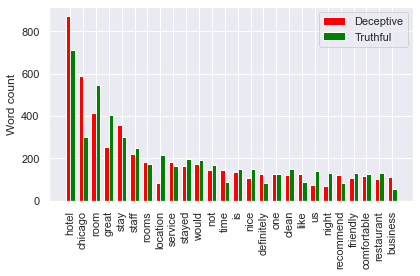

In [9]:
labels = list(word_count_dec_truth.keys())
values = list(word_count_dec_truth.values())
val_dec = [x[0] for x in values]
val_truthful = [x[1] for x in values]
ind = np.arange(len(labels))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, val_dec, width,
                color="red",
                label='Deceptive')
rects2 = ax.bar(ind + width/2, val_truthful, width,
                color="green",
                label='Truthful')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Word count')
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=90)
fig.tight_layout()
plt.savefig('plots/word_count_comparison.png', dpi=2000)
plt.show()

{'alpha': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ]),
 'fit_prior': [True, False]}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   15.0s finished


Best parameters
{'fit_prior': True, 'alpha': 1.7241379310344829}


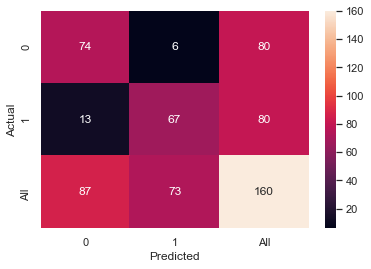

Metrics: 
   Accuracy: 0.881250 
   Precision: 0.917808 
   Recall: 0.837500 
   F1: 0.875817


In [36]:
# commented out code was used for comparing MNB with different preprocessing steps
#for y_test, X_test, y_train, X_train in zip(y_test_list, X_test_list, y_train_list, X_train_list):
alpha = np.linspace(start = 0.0, stop = 10.0, num = 30)
fit_prior = [True, False]

# Create the random grid
random_grid = {'alpha': alpha,
               'fit_prior': fit_prior}
pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
mnb = MultinomialNB()
# Random search of parameters, using 3 fold cross validation, 
# search across 60 different combinations, and use all available cores
mnb_random = RandomizedSearchCV(estimator = mnb, param_distributions = random_grid, n_iter = 60, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='f1')

# Fit the random search model
mnb_random.fit(X_train, y_train)

# print the best parameters
print("Best parameters")
print(mnb_random.best_params_)

# The best model
mnb_best_random = mnb_random.best_estimator_

# Predict Class
mnb_random_y_pred = mnb_best_random.predict(X_test)

# Accuracy 
mnb_cm, mnb_metrics = getModelInfo(y_test, mnb_random_y_pred)
metrics_list.append(mnb_metrics)


Standard configuration 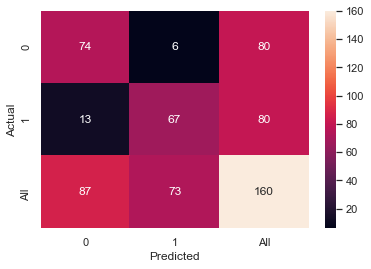
Best parameters
{'fit_prior': True, 'alpha': 1.7241379310344829}

Metrics: 
   Accuracy: 0.881250 
   Precision: 0.917808 
   Recall: 0.837500 
   F1: 0.875817
   

Stemming cv=10 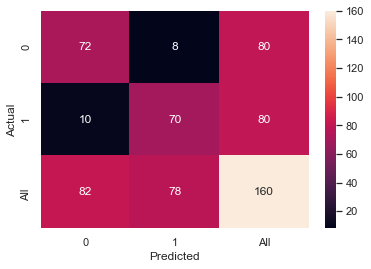
Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}

Metrics: 
   Accuracy: 0.887500 
   Precision: 0.897436 
   Recall: 0.875000 
   F1: 0.886076
   
Lemmatization cv=10 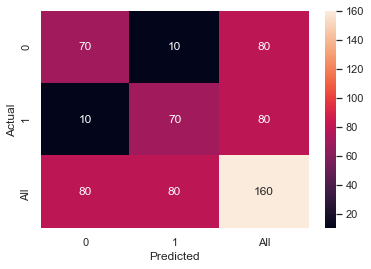
Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}

Metrics: 
   Accuracy: 0.875000 
   Precision: 0.875000 
   Recall: 0.875000 
   F1: 0.875000

Comparison of different preprocessing steps
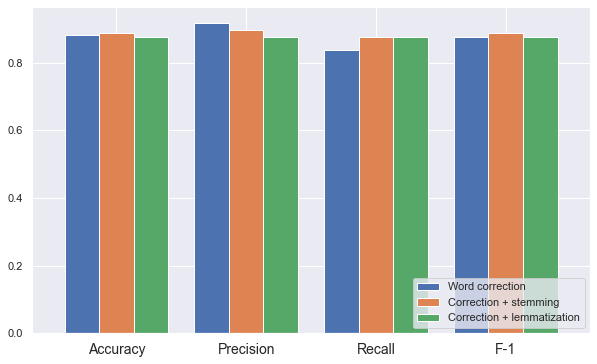

In [37]:
# functions used for CNN
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [7]:
# Model constants.
max_features = 20000
embedding_dim = 100
sequence_length = 300

# Load data
data_path = os.getcwd() + "/data/keras_train"
data_dir = pathlib.Path(data_path)
samples_train = []
labels_train = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        samples_train.append(content)
        labels_train.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples_train))


data_path_test = os.getcwd() + "/data/keras_test"
data_dir_test = pathlib.Path(data_path_test)
samples_test = []
labels_test = []
class_names_test = []
class_index = 0

for dirname in sorted(os.listdir(data_dir_test)):
    class_names_test.append(dirname)
    dirpath = data_dir_test / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        samples_test.append(content)
        labels_test.append(class_index)
    class_index += 1
    
vectorizer = TextVectorization(max_tokens=max_features, 
                               output_mode="int",
                               output_sequence_length=sequence_length)
text_ds = tf.data.Dataset.from_tensor_slices(samples_train).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
num_tokens = len(voc) + 2
hits = 0
misses = 0

print("Number of tokens: " + str(num_tokens))

x_train_cnn = vectorizer(np.array([[s] for s in samples_train])).numpy()
x_test_cnn = vectorizer(np.array([[s] for s in samples_test])).numpy()

y_train_cnn = np.array(labels_train)
y_test_cnn = np.array(labels_test)

Processing deceptive, 320 files found
Processing truthful, 320 files found
Classes: ['deceptive', 'truthful']
Number of samples: 640
Processing deceptive, 80 files found
Processing truthful, 80 files found
Number of tokens: 5314


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 19.5min finished


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Time:  1212.1450518000001
RandomizedSearchCV(cv=10,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F10A8B3188>,
                   n_iter=5, n_jobs=-1,
                   param_distributions={'embedding_dim': [100],
                                        'kernel_size': [3, 5, 7],
                                        'maxlen': [500],
                                        'num_filters': [32, 64, 128, 256],
                                        'vocab_size': [5000]},
                   random_state=42, scoring='f1', verbose=2)
0.8589743589743589
Best parameters
{'vocab_size': 5000, 'num_filt

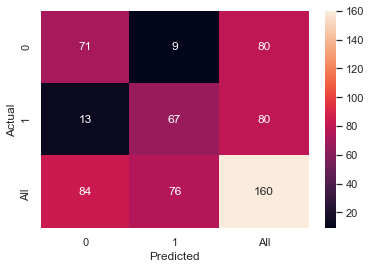

Metrics: 
   Accuracy: 0.862500 
   Precision: 0.881579 
   Recall: 0.837500 
   F1: 0.858974


In [41]:
start = timeit.default_timer()
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(None,), dtype="int64", name="input"))
    model.add(layers.Embedding(max_features, embedding_dim))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(num_filters, kernel_size, padding="valid", activation="relu", strides=3))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = "sigmoid", name="predictions"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

epochs = 20
embedding_dim = 100
maxlen = 500
param_grid = dict(num_filters=[32, 64, 128, 256],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])

model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=10, verbose=2, 
                          random_state = 42,
                          n_jobs = -1,
                          scoring='f1',                          
                          n_iter=5)
grid_result = grid.fit(x_train_cnn, y_train_cnn)

# Evaluate testing set
test_accuracy = grid.score(x_test_cnn, y_test_cnn)

stop = timeit.default_timer()
print('Time: ', stop - start)  
print(grid_result)
print(test_accuracy)
# print the best parameters
print("Best parameters")
print(grid_result.best_params_)

# The best model
best_random = grid_result.best_estimator_

# Predict Class
random_y_pred_cnn = np.concatenate(best_random.predict(x_test_cnn))
cnn_cm, cnn_metrics = getModelInfo(y_test_cnn, random_y_pred_cnn)

In [5]:

model = keras.Sequential()
model.add(tf.keras.Input(shape=(None,), dtype="int64", name="input"))
model.add(layers.Embedding(max_features, embedding_dim))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, 5, padding="valid", activation="relu", strides=3))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = "sigmoid", name="predictions"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [40]:
# get embeddings from GloVe
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

# Prepare embedding matrix
glove = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        glove[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 4720 words (592 misses)


In [42]:
np.random.seed(420)
start = timeit.default_timer()
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(None,), dtype="int64", name="input"))
    model.add(layers.Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(glove),
        trainable=False,
    ))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(num_filters, kernel_size, padding="valid", activation="relu", strides=3))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = "sigmoid", name="predictions"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


maxlen = 500
param_grid = dict(num_filters=[32, 64, 128, 256],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])

model = KerasClassifier(build_fn=create_model,
                        epochs = 80,
                        batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=10, verbose=2, 
                          random_state = 42,
                          n_jobs = -1,
                          scoring='f1',                          
                          n_iter=5)
grid_result = grid.fit(x_train_cnn, y_train_cnn)

# Evaluate testing set
test_accuracy = grid.score(x_test_cnn, y_test_cnn)

stop = timeit.default_timer()
print('Time: ', stop - start)  
print(grid_result)
print(test_accuracy)
print(grid_result.best_params_)


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 23.3min finished


Time:  1474.0669085999998
RandomizedSearchCV(cv=10,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F110D94D88>,
                   n_iter=5, n_jobs=-1,
                   param_distributions={'embedding_dim': [100],
                                        'kernel_size': [3, 5, 7],
                                        'maxlen': [500],
                                        'num_filters': [32, 64, 128, 256],
                                        'vocab_size': [5000]},
                   random_state=42, scoring='f1', verbose=2)
0.6917293233082706
{'vocab_size': 5000, 'num_filters': 64, 'maxlen': 500, 'kernel_size': 7, 'embedding_dim': 100}
0.3607116761469934


Best parameters
{'vocab_size': 5000, 'num_filters': 64, 'maxlen': 500, 'kernel_size': 7, 'embedding_dim': 100}


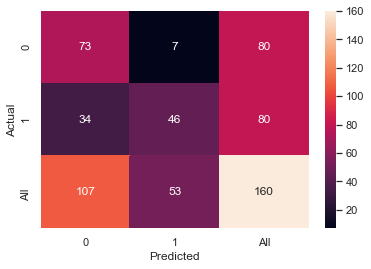

Metrics: 
   Accuracy: 0.743750 
   Precision: 0.867925 
   Recall: 0.575000 
   F1: 0.691729


In [43]:
# print the best parameters
print("Best parameters")
print(grid_result.best_params_)

# The best model
best_random = grid_result.best_estimator_

# Predict Class
random_y_pred = np.concatenate(best_random.predict(x_test_cnn))
cnn_embed_metrics, cnn_embed_metrics = getModelInfo(y_test_cnn, random_y_pred)


In [ ]:
metrics_list.append(cnn_metrics)
metrics_list.append(cnn_embed_metrics)

Algorithm  Multinomial Naive Bayes       CNN  CNN + Glove Embedding
Accuracy                  0.881250  0.862500               0.743750
Precision                 0.917808  0.881579               0.867925
Recall                    0.837500  0.837500               0.575000
F-1                       0.875817  0.858974               0.691729


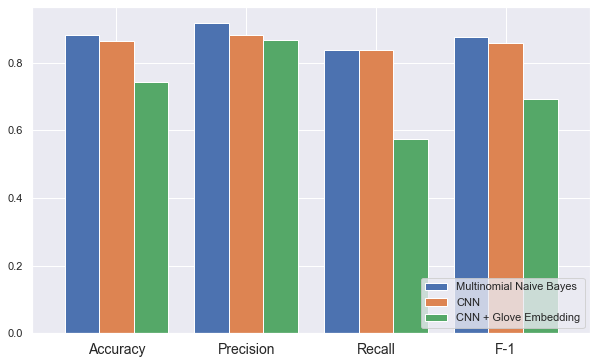

                         Accuracy  Precision  Recall       F-1
Algorithm                                                     
Multinomial Naive Bayes   0.88125   0.917808  0.8375  0.875817
CNN                       0.86250   0.881579  0.8375  0.858974
CNN + Glove Embedding     0.74375   0.867925  0.5750  0.691729


In [50]:
metrics_list
plotMetricsComparison(metrics_list)
save_metrics(metrics_list)

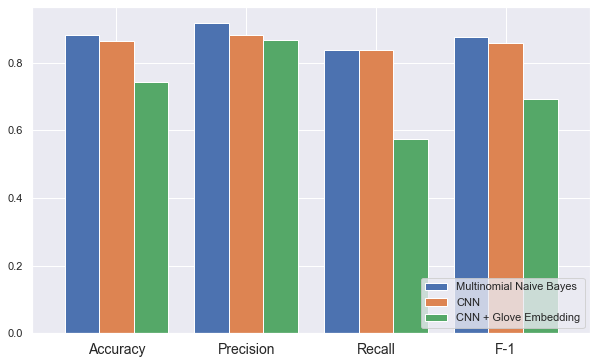
                         Accuracy  Precision  Recall       F-1
                         
Algorithm                                                     

Multinomial Naive Bayes   0.88125   0.917808  0.8375  0.875817

CNN                       0.86250   0.881579  0.8375  0.858974

CNN + Glove Embedding     0.74375   0.867925  0.5750  0.691729

In [53]:
from statsmodels.stats.contingency_tables import mcnemar
# Test if MNB and CNN are significantly different in classification

preds = pd.DataFrame({'MNB':mnb_random_y_pred, 'CNN':random_y_pred_cnn})
contingency_table = pd.crosstab(preds['MNB'], preds['CNN'])
print(contingency_table)
result = mcnemar(contingency_table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

CNN   0   1
MNB        
0    74  13
1    10  63
statistic=10.000, p-value=0.678
Same proportions of errors (fail to reject H0)


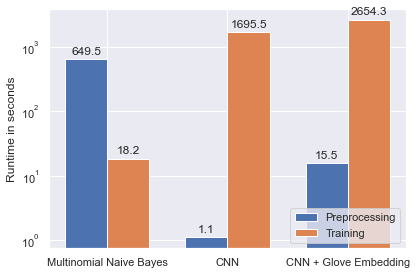

In [13]:
def plotRuntimeComparison(metrics_list, title=""):
    metrics_df = pd.DataFrame(metrics_list, columns=["Preprocessing","Precision","Recall"], index=["Multinomial Naive Bayes", "CNN", "CNN + Glove Embedding"])
    metrics_df.index.name = "Algorithm"
    print(metrics_df.transpose())
    ax = metrics_df.transpose().plot(kind='bar', legend=True, width=0.8, figsize=(10,6))
    plt.legend(loc='lower right')
    plt.xticks(fontsize=14, rotation=0)
    plt.savefig("plots/" + title + '.png')
    plt.show()    
    print(metrics_df)
    
N = 3
labels = ["Multinomial Naive Bayes", "CNN", "CNN + Glove Embedding"]
men_means = [649.5, 1.1, 15.5]
women_means = [18.2, 1695.5, 2654.3]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Preprocessing')
rects2 = ax.bar(x + width/2, women_means, width, label='Training')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Runtime in seconds')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
plt.yscale('log')
plt.legend(loc='lower right')

fig.tight_layout()

plt.show()